In [ ]:
# https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms


import matplotlib.pyplot as plt
import numpy as np

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

## GET data 

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [3]:
inputs, labels = next(iter(trainloader))

In [19]:
inputs.shape

torch.Size([4, 3, 32, 32])

In [4]:
labels

tensor([3, 2, 2, 2])

In [5]:
torch.where(labels<5, 0, 1)

tensor([0, 0, 0, 0])

## Show data 

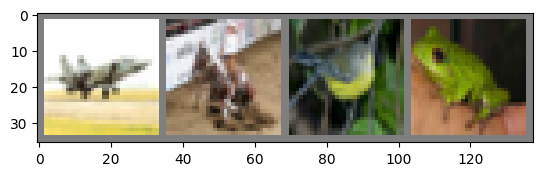

plane horse bird  frog 


In [6]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [7]:
images.shape

torch.Size([4, 3, 32, 32])

## Define model

In [8]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) # in_channels, out_channels, kernel_size
        # it resuts in [out_ch, in_ch, k_h, k_w]
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # 400
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

## Define loss and optimizer

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## Train the network

In [10]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        labels = torch.where(labels<5, 0, 1)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 0.693
[1,  4000] loss: 0.690
[1,  6000] loss: 0.679
[1,  8000] loss: 0.657
[1, 10000] loss: 0.634
[1, 12000] loss: 0.634
[2,  2000] loss: 0.603
[2,  4000] loss: 0.601
[2,  6000] loss: 0.589
[2,  8000] loss: 0.580
[2, 10000] loss: 0.579
[2, 12000] loss: 0.578
Finished Training


In [26]:
def save_model(dst_file, model, img_size=32):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    example = torch.zeros(1, 3, img_size, img_size).to("cpu") # nie wysyłam do gpu modelu w tym przykladzie
    
    with torch.no_grad():
        traced_script_module = torch.jit.trace(model, example)
        torch.jit.save(traced_script_module, dst_file)

In [27]:
#save model
PATH = './model.pt'
save_model(PATH, net, img_size=32)

In [8]:
# #save model
# PATH = './cifar_net.pth'
# torch.save(net.state_dict(), PATH)

## Testing

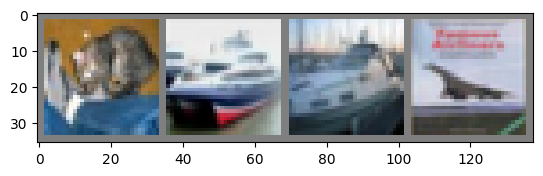

GroundTruth:  cat   ship  ship  plane


In [9]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [10]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [11]:
outputs = net(images)

In [12]:
outputs

tensor([[-0.8206, -2.0759,  0.7344,  2.8581, -0.0260,  1.7770,  0.6872, -1.0072,
         -0.5235, -1.7866],
        [ 4.4836,  3.5545, -1.6367, -3.3570, -1.7963, -3.5104, -3.1195, -3.6368,
          4.7735,  1.6331],
        [ 2.3841,  1.3665,  0.6940, -1.3469, -0.6529, -1.6775, -1.7937, -1.2607,
          1.3310,  0.6126],
        [ 4.1361,  0.1166,  0.8388, -2.0781,  0.0929, -2.6638, -2.1869, -1.4506,
          2.4125, -0.3837]], grad_fn=<AddmmBackward>)

In [13]:
_, predicted = torch.max(outputs, 1)

print(predicted)
print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))


tensor([3, 8, 0, 0])
Predicted:  cat   ship  plane plane


In [14]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 54 %


In [15]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')


Accuracy for class: plane is 64.5 %
Accuracy for class: car   is 80.0 %
Accuracy for class: bird  is 36.9 %
Accuracy for class: cat   is 40.9 %
Accuracy for class: deer  is 48.5 %
Accuracy for class: dog   is 48.4 %
Accuracy for class: frog  is 52.7 %
Accuracy for class: horse is 61.7 %
Accuracy for class: ship  is 61.2 %
Accuracy for class: truck is 55.1 %


## On GPU

In [16]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [17]:
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [ ]:
inputs, labels = data[0].to(device), data[1].to(device) # GPU
inputs, labels = data # CPU


In [19]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        
        # inputs, labels = data[0].to(device), data[1].to(device) # GPU
        inputs, labels = data # CPU

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same